# ⚡ Model 4: ResNet-50 + Attention for Facial Emotion Recognition

This notebook:
- Loads pretrained ResNet-50
- Adds spatial attention (CBAM-style)
- Fine-tunes with FER-2013 dataset

In [11]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [12]:

# Dataset and transforms
train_dir = 'Data/train'
test_dir = 'Data/test'

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

full_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes


In [13]:

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = torch.sigmoid(self.conv(x_cat))
        return x * attention


In [14]:

# Build ResNet-50 with spatial attention block
class ResNet50WithAttention(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet50WithAttention, self).__init__()
        self.base_model = models.resnet50(pretrained=True)

        # Remove last FC layer
        self.base_model.fc = nn.Identity()

        # Add attention
        self.attention = SpatialAttention()

        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)

        x = self.attention(x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = ResNet50WithAttention().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [16]:

# Train model
num_epochs = 5
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    val_acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch [1/5], Loss: 0.4189, Val Accuracy: 0.6309
Epoch [2/5], Loss: 0.2471, Val Accuracy: 0.6302
Epoch [3/5], Loss: 0.0840, Val Accuracy: 0.6579
Epoch [4/5], Loss: 0.0339, Val Accuracy: 0.6581
Epoch [5/5], Loss: 0.0324, Val Accuracy: 0.6523


In [17]:

# Test evaluation
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.numpy())

test_acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.6624


In [18]:
# :white_check_mark: Compute Test Accuracy
from sklearn.metrics import accuracy_score

model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.numpy())

test_acc = accuracy_score(test_labels, test_preds)
print(f":white_check_mark: Test Accuracy: {test_acc:.4f}")

:white_check_mark: Test Accuracy: 0.6624


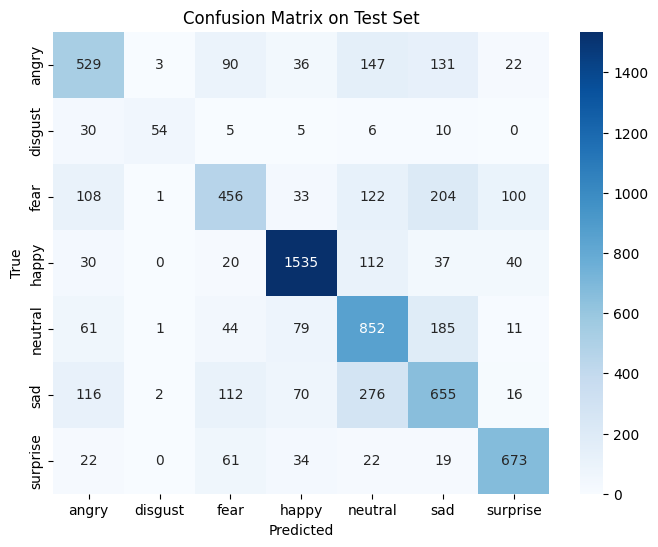

In [19]:
# 📊 Confusion Matrix for Test Set
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

<Figure size 800x600 with 0 Axes>

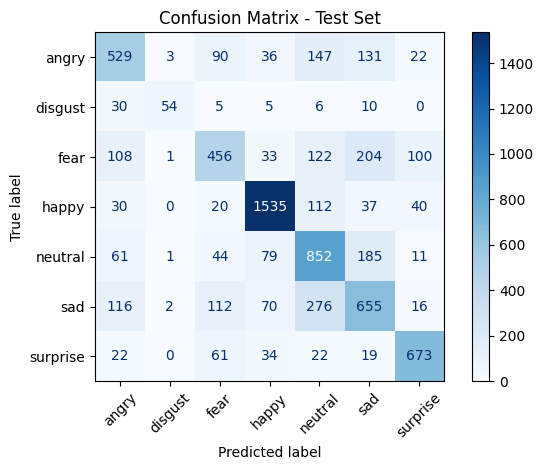

Classification Report:\n               precision    recall  f1-score   support

       angry       0.59      0.55      0.57       958
     disgust       0.89      0.49      0.63       110
        fear       0.58      0.45      0.50      1024
       happy       0.86      0.87      0.86      1774
     neutral       0.55      0.69      0.62      1233
         sad       0.53      0.53      0.53      1247
    surprise       0.78      0.81      0.80       831

    accuracy                           0.66      7177
   macro avg       0.68      0.63      0.64      7177
weighted avg       0.66      0.66      0.66      7177



In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(test_labels, test_preds, target_names=class_names)
print("Classification Report:\\n", report)

In [21]:
# Display the test image and prediction
if os.path.exists(test_image_path):
    original_image = Image.open(test_image_path).convert('L')
    plt.figure(figsize=(4, 4))
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Prediction: {predicted_class}\\nConfidence: {confidence*100:.2f}%")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f"Image file '{test_image_path}' not found.")

NameError: name 'test_image_path' is not defined

In [22]:

# Predict single image
test_image_path = 'my_image2.jpg'

image = Image.open(test_image_path).convert('L').convert('RGB')
image = test_transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(image)
    probs = torch.softmax(output, dim=1)
    _, predicted = torch.max(probs, 1)
    predicted_class = class_names[predicted.item()]
    confidence = probs[0][predicted.item()].item()

print(f"Predicted Emotion: {predicted_class} ({confidence*100:.2f}% confidence)")


Predicted Emotion: surprise (99.72% confidence)
